## Bias Mitigation with Disparate Impact Remover

This notebook is an example of bias mitigation with an pre-processing algorithm called Disparate Impact Remover. 

The library we are using to implement this algorithm is [AI Fairness 360](http://aif360.mybluemix.net/). 

The algorithm was introduced in the paper ["Certifying and removing disparate impact" by M. Feldman, S. A. Friedler, J. Moeller, C. Scheidegger, and S. Venkatasubramanian](https://arxiv.org/abs/1412.3756)

### Data
Import required libraries

In [2]:
from matplotlib import pyplot as plt

import numpy as np
from numpy.random import choice as np_choice
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

We are using a random seed so that the comments remain correct when rerunning this notebook

In [3]:
seed = 123
np.random.seed(seed)

We are going to create two unequal datasets
- The first is an unprivileged group where their mean is 5.5 and standard deviation 0.5. The `output` variable indicates if the individual received a favourable outcome (1) or unfavourable (0), the probability for a favourable outcome for this group is 0.5.
- The second a priviledged group, their mean is higher, 6, and the standard deviation 0.4. The probability for a favourable outcome for this group is 0.7.

In [24]:
unpriv = pd.DataFrame({'group':[0 for i in range(0, 400)],
                       'value':np.random.normal(5.5, 0.6, 400), 
                       'output':np.random.choice([0, 1], size=(400), p=[0.5, 0.5])})

In [25]:
priv = pd.DataFrame({'group':[1 for i in range(0, 1000)],
                     'value':np.random.normal(6, 0.4, 1000),
                     'output':np.random.choice([0, 1], size=(1000), p=[0.3, 0.7])})

We can plot the distributions on a graph to show the disparity between the values for the two groups

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


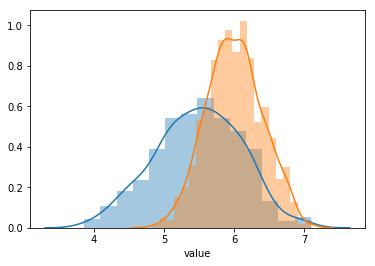

In [26]:
sns.distplot(unpriv["value"], hist=True, rug=False)
sns.distplot(priv["value"], hist=True, rug=False)

We create the final dataset combining the privileged and unprivileged groups

In [78]:
groups = priv.append([unpriv]).reset_index(drop=True)

We want a model to be able to find some sort of pattern so we decide that if `value` is less than 5.3 we assign the `output` value as 0 with probability 0.8

In [79]:
for i in np.arange(len(groups)):
    if (groups.at[i,"value"] < 5.3):
        groups.at[i,"output"] = np.random.choice([0, 1], p=[0.7, 0.3])
    elif (groups.at[i,"value"] > 6.2):
        groups.at[i,"output"] = np.random.choice([0, 1], p=[0.2, 0.8])

### Disparate Impact

We wish to evaluate if the unprivileged group is receiving similar treatment to the privileged group. Of course, as I purposely created this data to be unfair, we expect this to be untrue.

Disparate Impact is a metric to evaluate fairness. It compares the proportion of individuals that receive a positive output for two groups: an unprivileged group and a privileged group.

```Pr(Y=1|D=unprivileged) / Pr(Y=1|D=privileged)```

We can visualise the proportion of favourable outcomes for each of the groups

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


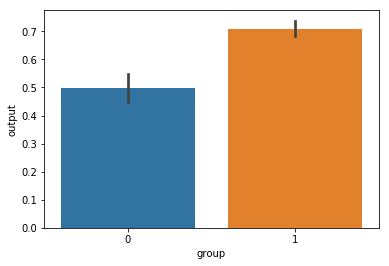

In [80]:
sns.barplot(x=groups["group"], y=groups["output"])

To calculate disparate impact we first calculate the proportions of the groups receiving favourable outcomes. We calculate a little function to do this

In [81]:
def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

We calculate the proportion of the unprivileged group receiving the favourable outcome

In [82]:
pr_unpriv = calc_prop(groups, "group", 0, "output", 1)
print(pr_unpriv)

0.4975


Next we calculate the proportion receiving the unfavourable outcome

In [83]:
pr_priv = calc_prop(groups, "group", 1, "output", 1)
print(pr_priv)

0.709


Finally, to calculate Disparate Impact, we divide the former by the latter

In [84]:
pr_unpriv / pr_priv

0.7016925246826516

The industry standard is a four-fifths rule: if the unprivileged group receives a positive outcome less than 80% of their proportion of the privilege group, this is a disparate impact violation. However, you may decide to increase this for your business.

In this scenario, we are below the threshold of 0.8 so we deem this to be unfair.

### Building an ML Model

If we build an ML model on biased data, it's predictions will replicate the bias, let's demonstrate that here.

We split our data into training and testing. The purpose of splitting the data is to be able to assess the quality of a predictive model when it is used on unseen data. When training, you will try to build a model that fits to the data as closely as possible, to be able to most accurately make a prediction. However, without a test set you run the risk of overfitting - the model works very well for the data it has seen but not for new data.

We will only be randomly splitting our data into test and train, with a 80/20 split.

In [160]:
train, test = \
    train_test_split(groups, stratify=groups["group"], test_size = 0.2, random_state = seed)

In [161]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

We build a logistic regression model passing the feature `value` and label `output`

In [162]:
lr=LogisticRegression(random_state=seed)
lr.fit(train[["value"]], train["output"])

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We can calculate the accruacy of our model on the test data

In [163]:
lr.score(test[["value"]], test["output"])

0.7107142857142857

We can capture the predictions for our test data to evaluate fairness

In [164]:
preds = lr.predict(test[["value"]])

We join the predictions with the group so we can filter accordingly

In [165]:
pred_df = pd.DataFrame({"group": test["group"], "preds": preds})

As before we calculate the proportion of the unprivileged group receiving the favourable outcome

In [168]:
lr_pr_unpriv = calc_prop(pred_df,"group",0,"preds",1)
print(lr_pr_unpriv)

0.75


Similarly for the privileged group

In [169]:
lr_pr_priv = calc_prop(pred_df,"group",1,"preds",1)
print(lr_pr_priv)

0.995


We then divide the former by the latter to get our Disparate Impact value

In [170]:
lr_pr_unpriv / lr_pr_priv

0.7537688442211056

As with our initial data, we see a substantially greater proportion of the privileged group recieving the favourable output and identify this to be unfair.

If this weren't a toy example and we were to put this model into production, this biased output could harm many people in the unprivileged group

### Disparate Impact Remover

As we saw in the initial diagram, the distributions of `value` for the two groups are significantly different. If you were to pick a data point at random, you'd be able to predict with reasonable confidence which group you selected from. This means that even though you're not explicitly including `group` as a feature in your model, it is still present. Disparate Impact Remover removes the ability to distinguish between the two.


To use AIF360's Disparate Impact Remover, we need to create a `BinaryLabelDataset` for the training and testing data

In [171]:
train_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=train,
                                label_names=['output'],
                                protected_attribute_names=['group'],
                                unprivileged_protected_attributes=['0'])
test_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=test,
                                label_names=['output'],
                                protected_attribute_names=['group'],
                                unprivileged_protected_attributes=['0'])

We then create a Disparate Impact Remover and specify the `repair_level`, this indicates how much you wish for the distributions of the groups to overlap. We will try with two values: 1.0 and 0.8

We create our first DisparateImpactRemover and fit and transform the train and test data

In [172]:
di = DisparateImpactRemover(repair_level=1.0)
rp_train = di.fit_transform(train_BLD)
rp_test = di.fit_transform(test_BLD)

Similarly we create the second DisparateImpactRemover and again fit and trainsform the train and test data

In [173]:
di_2 = DisparateImpactRemover(repair_level=0.8)
rp2_train = di_2.fit_transform(train_BLD)
rp2_test = di_2.fit_transform(test_BLD)

We create new training and test datasets with the repaired values

In [174]:
train_BLD.feature_names

['group', 'value']

In [175]:
rp_train_pd = pd.DataFrame(np.hstack([rp_train.features,rp_train.labels]),columns=["group","value","labels"])
rp_test_pd = pd.DataFrame(np.hstack([rp_test.features,rp_test.labels]),columns=["group","value","labels"])

In [176]:
rp2_train_pd = pd.DataFrame(np.hstack([rp2_train.features,rp2_train.labels]),columns=["group","value","labels"])
rp2_test_pd = pd.DataFrame(np.hstack([rp2_test.features,rp2_test.labels]),columns=["group","value","labels"])

We remind ourselves of the distributions of the values for the two groups

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


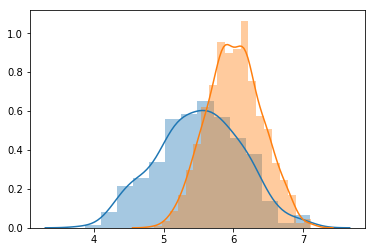

In [177]:
target_0_orig = train.loc[train['group'] == 0]
target_1_orig = train.loc[train['group'] == 1]

sns.distplot(target_0_orig[['value']], hist=True, rug=False)
sns.distplot(target_1_orig[['value']], hist=True, rug=False)

We next look at the distribution of the repaired data with `repair_level` 1.0

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


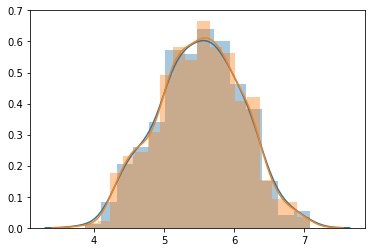

In [178]:
target_0_rep1 = rp_train_pd.loc[rp_train_pd['group'] == 0]
target_1_rep1 = rp_train_pd.loc[rp_train_pd['group'] == 1]

sns.distplot(target_0_rep1[['value']], hist=True, rug=False)
sns.distplot(target_1_rep1[['value']], hist=True, rug=False)

As you can see, you can no longer select a point without inferring which group it belongs to

We next look at the distribution of the repaired data with `repair_level` 0.8

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


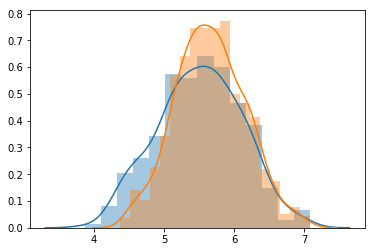

In [179]:
target_0_rep2 = rp2_train_pd.loc[rp2_train_pd['group'] == 0]
target_1_rep2 = rp2_train_pd.loc[rp2_train_pd['group'] == 1]

sns.distplot(target_0_rep2[['value']], hist=True, rug=False)
sns.distplot(target_1_rep2[['value']], hist=True, rug=False)

This time, the two distributions don't entirely overlap

Although the values change to remove bias, the ranking with the groups remain the same. We can test this looking at the top three values for each group and each dataset

First let's focus on the unprivileged group, viewing the smallest five values

In [186]:
target_0_orig.sort_values("value")[:5]

,group,output,value
701,0,0,3.872637
412,0,1,4.215382
175,0,1,4.233313
1060,0,0,4.236066
660,0,1,4.309020


So in ascending order, the smallest values are at index 701, 412, 175, 1060 and 660

We can check if they've changed when repairing our data

In [187]:
target_0_rep1.sort_values("value")[:5]

,group,value,labels
701,0.0,3.872637,0.0
412,0.0,4.215382,1.0
175,0.0,4.233313,1.0
1060,0.0,4.236066,0.0
660,0.0,4.309020,1.0


Neither the order nor the values have changed. If it hasn't changed with a `repair_level` of 1.0, we don't expect it to change on the second repaired data but will check anyway

In [188]:
target_0_rep2.sort_values("value")[:5]

,group,value,labels
701,0.0,3.872637,0.0
412,0.0,4.215382,1.0
175,0.0,4.233313,1.0
1060,0.0,4.236066,0.0
660,0.0,4.309020,1.0


Next we wish to look at the smallest five values for the privileged group

In [189]:
target_1_orig.sort_values("value")[:5]

,group,output,value
401,1,0,4.861829
546,1,0,5.015805
294,1,1,5.020209
394,1,0,5.064415
326,1,0,5.091649


In ascending order we have indexes 401, 546, 294, 394 and 326

We then compare this with the first repaired dataset

In [190]:
target_1_rep1.sort_values("value")[:5]

,group,value,labels
546,1.0,3.872637,0.0
401,1.0,3.872637,0.0
294,1.0,4.215382,1.0
394,1.0,4.215382,0.0
326,1.0,4.215382,0.0


We have the same five indexes but as 546 and 401 have the same value, the order has slightly change. Also note how these values match the lowest in unprivileged group

We check with the second repaired dataset

In [191]:
target_1_rep2.sort_values("value")[:5]

,group,value,labels
401,1.0,4.374618,0.0
546,1.0,4.451406,0.0
294,1.0,4.477112,1.0
394,1.0,4.480953,0.0
326,1.0,4.517633,0.0


As expected, the ranking has stayed the same

### Building an Unbiased Model

Now that we've repaired the values to remove bias, we can build a new model and confirm if the Disparate Impact has been removed

We build another logistic regression model, this time with the repaired data (`repair_level`=1.0)

In [114]:
lr_di=LogisticRegression()
lr_di.fit(rp_train_pd[["value"]], rp_train_pd["labels"])

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We can score our test data comparing with the previous accuracy of 71%. If we believe that the labels are biased (which they are as we created them that way), then the accuracy we see at the beginning is untrue. Although it is our ground truth, we are capturing unfairness that we wish to remove. Consequently, we expect our accuracy value to be reduced. Also, in a business context, we may need to consider other performances metrics (precision, recall, F1 score).

In [115]:
lr_di.score(rp_test_pd[["value"]], rp_test_pd["labels"])

0.675

As before, we create a dataframe with the predictions from our test data and their group assignment

In [116]:
di_preds = lr_di.predict(rp_test_pd[["value"]])

In [117]:
di_pred_df = pd.DataFrame({"group": rp_test_pd["group"], "preds": di_preds})

We again calculate the proportion of each group receiving the favourable outcome

In [118]:
di_lr_pr_unpriv = calc_prop(di_pred_df,"group",0,"preds",1)
print(di_lr_pr_unpriv)

0.925


In [119]:
di_lr_pr_priv = calc_prop(di_pred_df,"group",1,"preds",1)
print(di_lr_pr_priv)

0.925


Then calculate the Disparate Impact

In [120]:
di_lr_pr_unpriv / di_lr_pr_priv

1.0

We have a perfect ratio, the two groups are being treated equally

We repeat with our second repaired dataset (`repair_level`=0.8)

In [121]:
lr_di2=LogisticRegression()
lr_di2.fit(rp2_train_pd[["value"]], rp2_train_pd["labels"])

/Users/staceyro/anaconda/envs/aif360/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [122]:
lr_di2.score(rp2_test_pd[["value"]], rp2_test_pd["labels"])

0.6892857142857143

Our accuracy is still lower than the original data. However, it is higher than the fully repaired dataset. 

This is a challenge for AI practitioners, when you know you have biased data, you realise that the ground truth you're building a model with doesn't necessarily reflect reality.

Again we create a dataframe with each data points group and prediction

In [123]:
di2_preds = lr_di2.predict(rp2_test_pd[["value"]])

In [124]:
di2_pred_df = pd.DataFrame({"group": rp2_test_pd["group"], "preds": di2_preds})

We calculate the proportion of the unprivileged group receiving the favourable outcome

In [125]:
di2_lr_pr_unpriv = calc_prop(di2_pred_df,"group",0,"preds",1)
print(di2_lr_pr_unpriv)

0.9


Similarly for the privileged group

In [126]:
di2_lr_pr_priv = calc_prop(di2_pred_df,"group",1,"preds",1)
print(di2_lr_pr_priv)

0.975


Then our final Disparate Impact

In [127]:
di2_lr_pr_unpriv / di2_lr_pr_priv

0.9230769230769231

Still fair!

It is also possible to calculate using AIF360's BinaryLabelDatasetMetric class

First we create a copy of our repaired BinaryLabelDataset and replace the labels with our logistic regression predictions

In [198]:
rp2_test_pred = rp2_test.copy()
rp2_test_pred.labels = di2_preds

Then we create a new BinaryLabelDatasetMetric with this dataset and specifying the privileged and unprivileged groups

In [199]:
bldm = BinaryLabelDatasetMetric(rp2_test_pred, 
                                    privileged_groups=[{"group": 1}], 
                                    unprivileged_groups=[{"group": 0}])

We then simply call `disparate_impact`

In [200]:
bldm.disparate_impact()

0.9230769230769231